In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style for visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print(" All packages installed and imported successfully!")

 All packages installed and imported successfully!


In [3]:
def generate_synthetic_dataset(n_samples=1000, seed=42):
    """
    Generate synthetic house price dataset with realistic correlations
    """
    np.random.seed(seed)

    # Define locations and their price multipliers
    locations = ['Downtown', 'Suburbs', 'Waterfront', 'Rural', 'Uptown']
    location_multipliers = {
        'Downtown': 1.3,
        'Suburbs': 1.0,
        'Waterfront': 1.5,
        'Rural': 0.7,
        'Uptown': 1.2
    }

    data = []

    for i in range(n_samples):
        # Generate base features
        sqft = np.random.randint(800, 4000)
        bedrooms = np.random.randint(1, 6)
        bathrooms = np.random.randint(1, 4)
        age = np.random.randint(0, 51)
        location = np.random.choice(locations)
        garage = np.random.choice([0, 1, 2])
        has_pool = np.random.choice([0, 1], p=[0.7, 0.3])

        # Calculate price with realistic formula
        base_price = 50000 + (sqft * 150)
        base_price += bedrooms * 25000
        base_price += bathrooms * 15000
        base_price -= age * 1000
        base_price += garage * 12000
        base_price += has_pool * 30000

        # Apply location multiplier
        base_price *= location_multipliers[location]

        # Add realistic noise
        noise = np.random.normal(0, 30000)
        price = max(50000, base_price + noise)

        data.append({
            'sqft': sqft,
            'bedrooms': bedrooms,
            'bathrooms': bathrooms,
            'age': age,
            'location': location,
            'garage': garage,
            'has_pool': has_pool,
            'price': round(price, 2)
        })

    df = pd.DataFrame(data)
    return df

# Generate dataset
print(" Generating synthetic dataset...")
df = generate_synthetic_dataset(n_samples=1000)
print(f" Dataset generated: {df.shape[0]} rows, {df.shape[1]} columns")
print("\nFirst few rows:")
print(df.head())


 Generating synthetic dataset...
 Dataset generated: 1000 rows, 8 columns

First few rows:
   sqft  bedrooms  bathrooms  age    location  garage  has_pool       price
0  3974         4          1   14  Waterfront       0         0  1093145.19
1  2282         5          3   21      Uptown       1         1   696235.58
2  3653         2          1   32       Rural       1         0   398317.47
3  1882         2          3   46  Waterfront       2         1   636081.37
4  2328         3          1   50      Uptown       0         0   509032.38


EXPLORATORY DATA ANALYSIS

 Dataset Statistics:
             sqft     bedrooms    bathrooms          age       garage  \
count  1000.00000  1000.000000  1000.000000  1000.000000  1000.000000   
mean   2373.20600     2.902000     1.989000    24.599000     1.004000   
std     941.23967     1.395114     0.810886    14.665718     0.820156   
min     800.00000     1.000000     1.000000     0.000000     0.000000   
25%    1584.25000     2.000000     1.000000    12.000000     0.000000   
50%    2331.50000     3.000000     2.000000    24.000000     1.000000   
75%    3218.25000     4.000000     3.000000    38.000000     2.000000   
max    3999.00000     5.000000     3.000000    50.000000     2.000000   

          has_pool         price  
count  1000.000000  1.000000e+03  
mean      0.309000  5.728210e+05  
std       0.462312  2.275782e+05  
min       0.000000  1.450278e+05  
25%       0.000000  3.944275e+05  
50%       0.000000  5.507485e+05  
75%       1.000000  7.250252e+05  
max       1.00

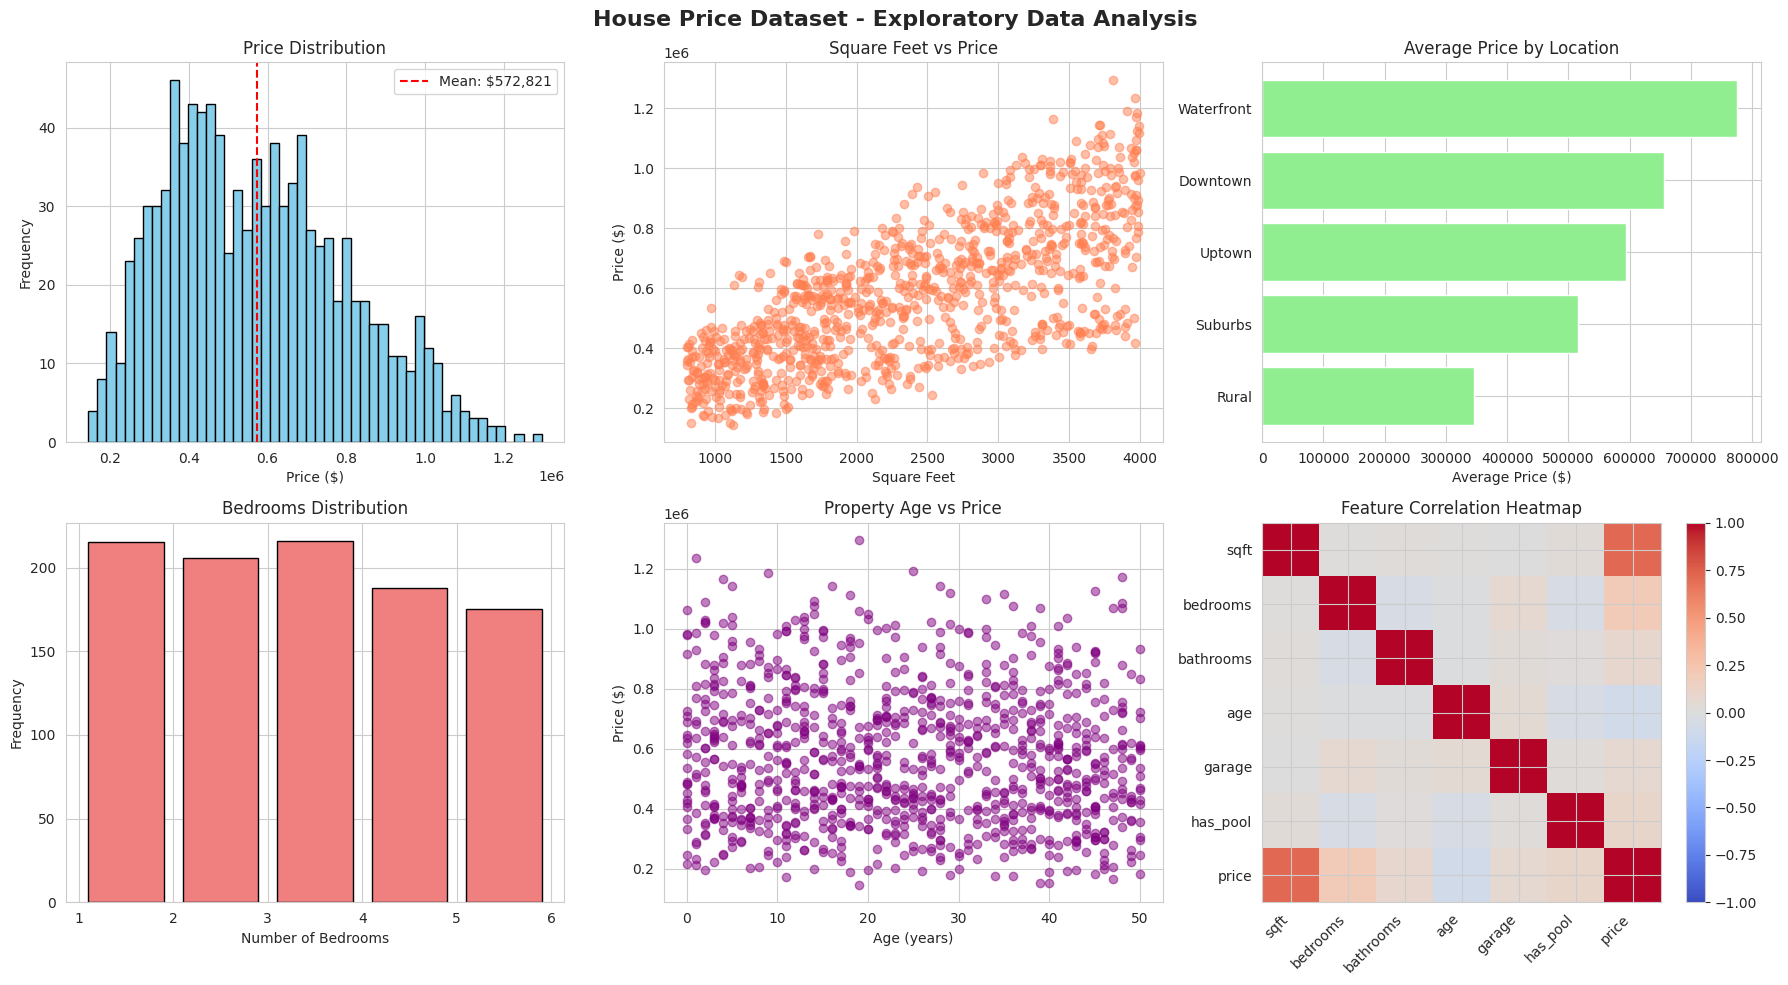

In [4]:
print("EXPLORATORY DATA ANALYSIS")

# Basic statistics
print("\n Dataset Statistics:")
print(df.describe())

print("\n Data Types:")
print(df.dtypes)

print("\n Missing Values:")
print(df.isnull().sum())

# Visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('House Price Dataset - Exploratory Data Analysis', fontsize=16, fontweight='bold')

# 1. Price distribution
axes[0, 0].hist(df['price'], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Price Distribution')
axes[0, 0].set_xlabel('Price ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df['price'].mean(), color='red', linestyle='--', label=f'Mean: ${df["price"].mean():,.0f}')
axes[0, 0].legend()

# 2. Square feet vs Price
axes[0, 1].scatter(df['sqft'], df['price'], alpha=0.5, color='coral')
axes[0, 1].set_title('Square Feet vs Price')
axes[0, 1].set_xlabel('Square Feet')
axes[0, 1].set_ylabel('Price ($)')

# 3. Location-wise average price
location_avg = df.groupby('location')['price'].mean().sort_values()
axes[0, 2].barh(location_avg.index, location_avg.values, color='lightgreen')
axes[0, 2].set_title('Average Price by Location')
axes[0, 2].set_xlabel('Average Price ($)')

# 4. Bedrooms distribution
axes[1, 0].hist(df['bedrooms'], bins=range(1, 7), color='lightcoral', edgecolor='black', rwidth=0.8)
axes[1, 0].set_title('Bedrooms Distribution')
axes[1, 0].set_xlabel('Number of Bedrooms')
axes[1, 0].set_ylabel('Frequency')

# 5. Age vs Price
axes[1, 1].scatter(df['age'], df['price'], alpha=0.5, color='purple')
axes[1, 1].set_title('Property Age vs Price')
axes[1, 1].set_xlabel('Age (years)')
axes[1, 1].set_ylabel('Price ($)')

# 6. Correlation heatmap (numeric features only)
numeric_cols = ['sqft', 'bedrooms', 'bathrooms', 'age', 'garage', 'has_pool', 'price']
correlation = df[numeric_cols].corr()
im = axes[1, 2].imshow(correlation, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
axes[1, 2].set_xticks(range(len(numeric_cols)))
axes[1, 2].set_yticks(range(len(numeric_cols)))
axes[1, 2].set_xticklabels(numeric_cols, rotation=45, ha='right')
axes[1, 2].set_yticklabels(numeric_cols)
axes[1, 2].set_title('Feature Correlation Heatmap')
plt.colorbar(im, ax=axes[1, 2])

plt.tight_layout()
plt.show()

# Interactive plot with Plotly
fig_interactive = px.scatter(df, x='sqft', y='price', color='location',
                            size='bedrooms', hover_data=['bathrooms', 'age'],
                            title='Interactive: Square Feet vs Price (colored by Location)')
fig_interactive.show()

In [5]:
print("DATA PREPROCESSING")

# Create a copy for preprocessing
df_processed = df.copy()

# Encode categorical variables
print("\n Encoding categorical variables...")
label_encoder = LabelEncoder()
df_processed['location_encoded'] = label_encoder.fit_transform(df_processed['location'])

print(f"Location encoding: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

# Feature engineering - create new features
df_processed['price_per_sqft'] = df_processed['price'] / df_processed['sqft']
df_processed['total_rooms'] = df_processed['bedrooms'] + df_processed['bathrooms']
df_processed['is_new'] = (df_processed['age'] < 5).astype(int)

print("\n New features created:")
print("  - price_per_sqft")
print("  - total_rooms")
print("  - is_new (property less than 5 years old)")

# Select features for modeling
feature_columns = ['sqft', 'bedrooms', 'bathrooms', 'age', 'location_encoded',
                   'garage', 'has_pool', 'total_rooms', 'is_new']
target_column = 'price'

X = df_processed[feature_columns]
y = df_processed[target_column]

print(f"\n Feature matrix shape: {X.shape}")
print(f" Target vector shape: {y.shape}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\n Data split:")
print(f"  Training set: {X_train.shape[0]} samples")
print(f"  Testing set: {X_test.shape[0]} samples")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n Features scaled using StandardScaler")


DATA PREPROCESSING

 Encoding categorical variables...
Location encoding: {np.str_('Downtown'): np.int64(0), np.str_('Rural'): np.int64(1), np.str_('Suburbs'): np.int64(2), np.str_('Uptown'): np.int64(3), np.str_('Waterfront'): np.int64(4)}

 New features created:
  - price_per_sqft
  - total_rooms
  - is_new (property less than 5 years old)

 Feature matrix shape: (1000, 9)
 Target vector shape: (1000,)

 Data split:
  Training set: 800 samples
  Testing set: 200 samples

 Features scaled using StandardScaler


MODEL TRAINING

 Training Linear Regression model...
 Model trained successfully!

 Feature Importance (Coefficients):
            feature    coefficient
0              sqft  160223.741090
4  location_encoded   69741.320222
1          bedrooms   25075.180005
7       total_rooms   23942.091749
3               age  -22725.065194
6          has_pool   16718.154515
5            garage   10422.375931
2         bathrooms    3442.035524
8            is_new   -1474.822988


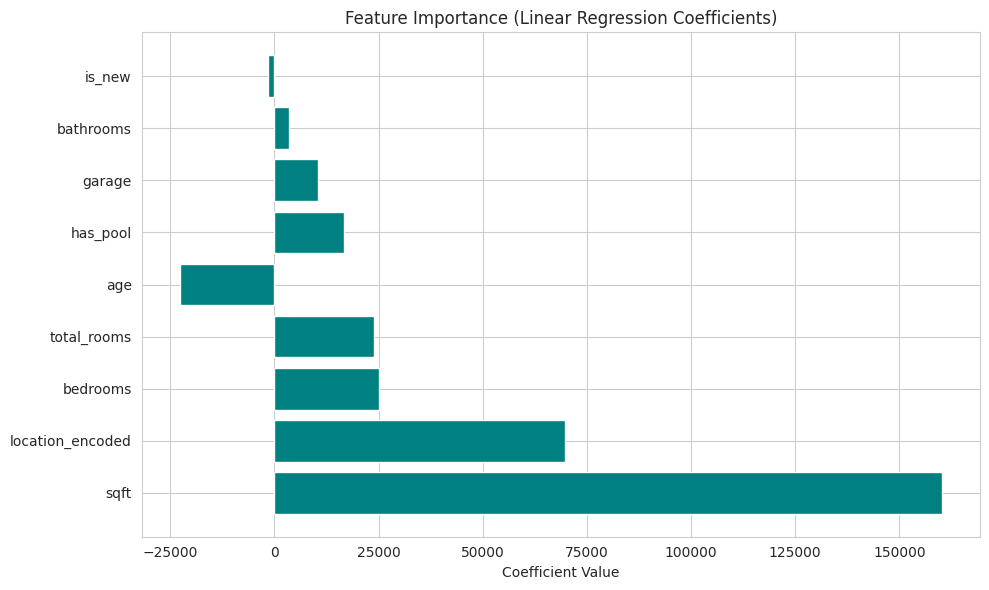

In [6]:
print("MODEL TRAINING")

# Train Linear Regression model
print("\n Training Linear Regression model...")
model = LinearRegression()
model.fit(X_train_scaled, y_train)

print(" Model trained successfully!")

# Feature importance (coefficients)
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'coefficient': model.coef_
}).sort_values('coefficient', key=abs, ascending=False)

print("\n Feature Importance (Coefficients):")
print(feature_importance)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['coefficient'], color='teal')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance (Linear Regression Coefficients)')
plt.tight_layout()
plt.show()

MODEL EVALUATION

 Model Performance Metrics:

Metric               Training             Testing
MAE                  $        105,546.94 $        105,355.19
RMSE                 $        130,060.69 $        130,510.53
R² Score                          0.6622              0.7084

 Performing 5-Fold Cross-Validation...
Cross-Validation MAE: $106,751.24 (+/- $13,744.90)


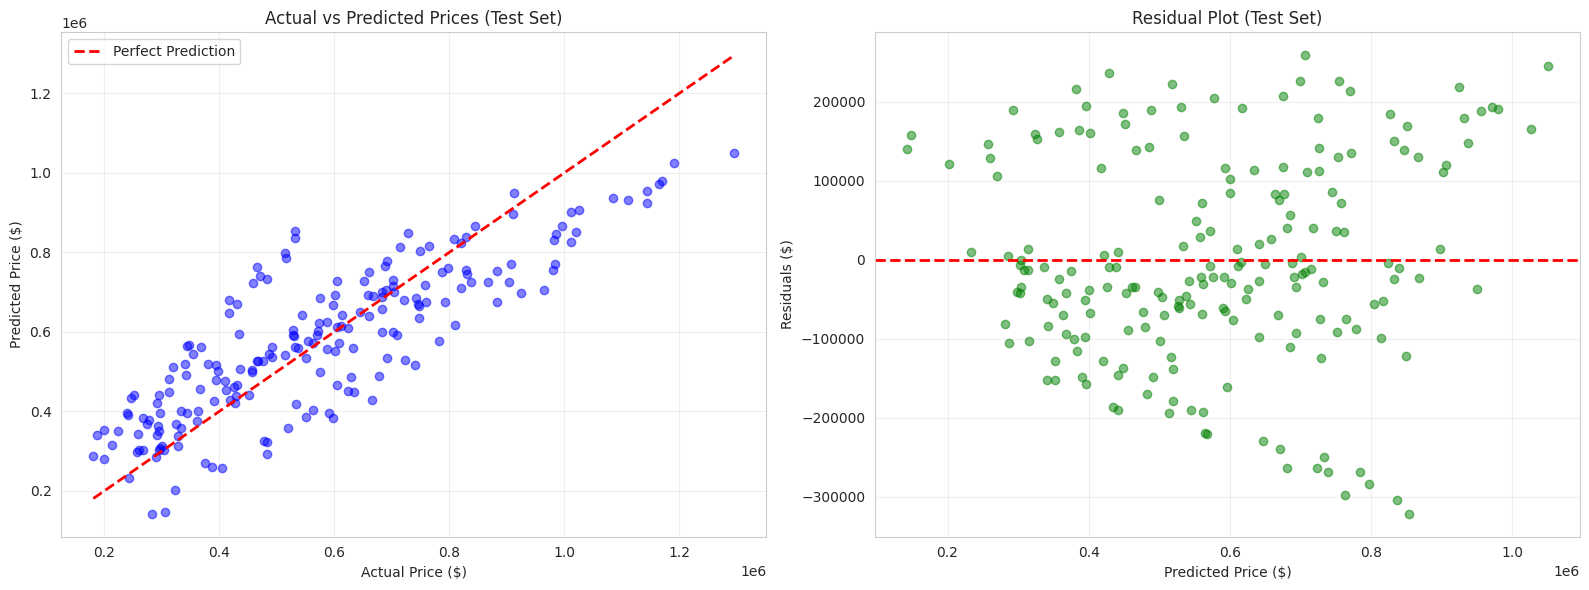

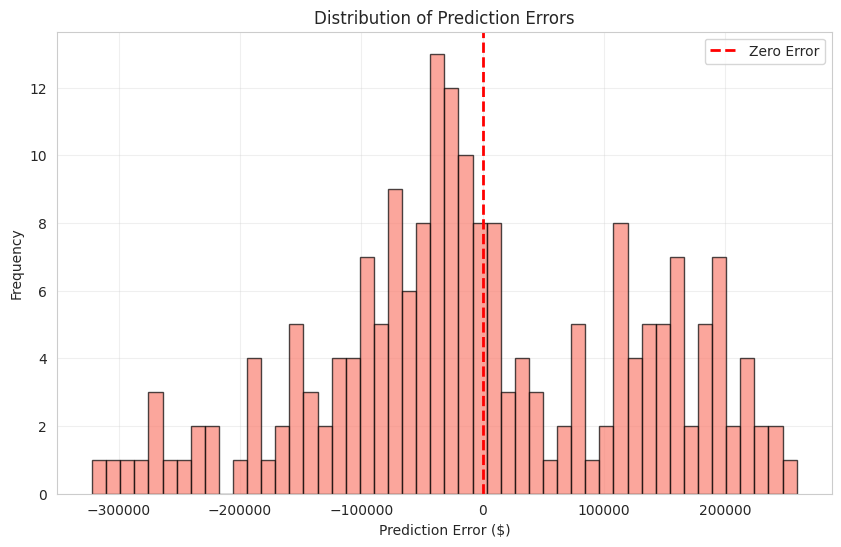

In [7]:
print("MODEL EVALUATION")

# Make predictions
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Calculate metrics
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("\n Model Performance Metrics:")
print(f"\n{'Metric':<20} {'Training':<20} {'Testing'}")
print("="*60)
print(f"{'MAE':<20} ${train_mae:>18,.2f} ${test_mae:>18,.2f}")
print(f"{'RMSE':<20} ${train_rmse:>18,.2f} ${test_rmse:>18,.2f}")
print(f"{'R² Score':<20} {train_r2:>19.4f} {test_r2:>19.4f}")

# Cross-validation
print("\n Performing 5-Fold Cross-Validation...")
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5,
                            scoring='neg_mean_absolute_error')
cv_mae = -cv_scores.mean()
print(f"Cross-Validation MAE: ${cv_mae:,.2f} (+/- ${cv_scores.std() * 2:,.2f})")

# Visualization of predictions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Actual vs Predicted (Test set)
axes[0].scatter(y_test, y_test_pred, alpha=0.5, color='blue')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Price ($)')
axes[0].set_ylabel('Predicted Price ($)')
axes[0].set_title('Actual vs Predicted Prices (Test Set)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residual plot
residuals = y_test - y_test_pred
axes[1].scatter(y_test_pred, residuals, alpha=0.5, color='green')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Price ($)')
axes[1].set_ylabel('Residuals ($)')
axes[1].set_title('Residual Plot (Test Set)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Distribution of errors
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, color='salmon', edgecolor='black', alpha=0.7)
plt.xlabel('Prediction Error ($)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [8]:
print("TEST PREDICTIONS")

def make_prediction(sqft, bedrooms, bathrooms, age, location, garage=0, has_pool=0):
    """Make a prediction using the trained model"""
    location_encoded = label_encoder.transform([location])[0]
    total_rooms = bedrooms + bathrooms
    is_new = 1 if age < 5 else 0

    features = np.array([[sqft, bedrooms, bathrooms, age, location_encoded,
                         garage, has_pool, total_rooms, is_new]])
    features_scaled = scaler.transform(features)
    prediction = model.predict(features_scaled)[0]

    return prediction

# Test cases
test_cases = [
    {"sqft": 2000, "bedrooms": 3, "bathrooms": 2, "age": 10, "location": "Suburbs", "garage": 2, "has_pool": 0},
    {"sqft": 3500, "bedrooms": 4, "bathrooms": 3, "age": 5, "location": "Waterfront", "garage": 2, "has_pool": 1},
    {"sqft": 1200, "bedrooms": 2, "bathrooms": 1, "age": 30, "location": "Rural", "garage": 1, "has_pool": 0},
    {"sqft": 2800, "bedrooms": 3, "bathrooms": 2, "age": 2, "location": "Downtown", "garage": 1, "has_pool": 0},
]

print("\n Sample Predictions:\n")
for i, case in enumerate(test_cases, 1):
    pred = make_prediction(**case)
    print(f"Test Case {i}:")
    print(f"  Features: {case}")
    print(f"  Predicted Price: ${pred:,.2f}")
    print(f"  Confidence Range: ${pred*0.9:,.2f} - ${pred*1.1:,.2f}\n")


TEST PREDICTIONS

 Sample Predictions:

Test Case 1:
  Features: {'sqft': 2000, 'bedrooms': 3, 'bathrooms': 2, 'age': 10, 'location': 'Suburbs', 'garage': 2, 'has_pool': 0}
  Predicted Price: $535,917.06
  Confidence Range: $482,325.36 - $589,508.77

Test Case 2:
  Features: {'sqft': 3500, 'bedrooms': 4, 'bathrooms': 3, 'age': 5, 'location': 'Waterfront', 'garage': 2, 'has_pool': 1}
  Predicted Price: $986,888.85
  Confidence Range: $888,199.96 - $1,085,577.73

Test Case 3:
  Features: {'sqft': 1200, 'bedrooms': 2, 'bathrooms': 1, 'age': 30, 'location': 'Rural', 'garage': 1, 'has_pool': 0}
  Predicted Price: $253,587.79
  Confidence Range: $228,229.01 - $278,946.57

Test Case 4:
  Features: {'sqft': 2800, 'bedrooms': 3, 'bathrooms': 2, 'age': 2, 'location': 'Downtown', 'garage': 1, 'has_pool': 0}
  Predicted Price: $565,137.16
  Confidence Range: $508,623.44 - $621,650.87

